In [1174]:
import numpy as np
import pandas as pd
import pretty_midi
import math
import time
import csv
import glob
import os
from os import listdir
#import import_ipynb
#import inpututil
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Activation, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.models import model_from_json
import matplotlib.pyplot as plt
import mido
from mido import MidiFile, MidiTrack, Message
from mido import MetaMessage
import music21
us = music21.environment.UserSettings()
us['musescoreDirectPNGPath'] = r"C:\Program Files\MuseScore 3\bin\MuseScore3.exe"
us['musicxmlPath'] = r"C:\Program Files\MuseScore 3\bin\MuseScore3.exe"

###I would like to give credit to Konstantin LACKNER with part of code for transform MIDI to Matrix representation

In [1194]:

def getNoteRangeAndTicks(files_dir, factor):
    ticks = []
    notes = []
    for file_dir in files_dir:
        file_path = "%s" %(file_dir)
        mid = MidiFile(file_path)                   
        
        for track in mid.tracks:
            num_ticks = 0           
            for message in track:
                if not isinstance(message, MetaMessage):
                    if message.type == "note_on" or message.type == "note_off":
                        notes.append(message.note)
                        num_ticks += round(message.time/factor)
                        #print("num_ticks:", num_ticks)
            ticks.append(num_ticks)
                    
    return min(notes), max(notes), max(ticks)


def Midi_to_Roll(files_dir, ticks, lowest_note, highest_note, factor):
    num_files = len(files_dir)          
    piano_roll = np.zeros((num_files, ticks, highest_note-lowest_note+1), dtype=np.float32)
    print(lowest_note, highest_note,highest_note-lowest_note+1)
    for i, file_dir in enumerate(files_dir):
        file_path = "%s" %(file_dir)
        mid = MidiFile(file_path)
        note_time_onoff = getNoteTimeOnOffArray(mid, factor)
        #print("note_time_onoff:", note_time_onoff)
        note_on_length = getNoteOnLengthArray(note_time_onoff)
        #print("note_on_length:", note_on_length)
        for message in note_on_length:

            piano_roll[i, message[1]:(message[1]+int(message[2]/2)), message[0]-lowest_note] = 1
    return piano_roll


def getNoteTimeOnOffArray(mid, factor):
    
    note_time_onoff_array = []  
    
    for track in mid.tracks:
        current_time = 0
        for message in track:
            if not isinstance(message, MetaMessage):
                if (message.type) == "note_on" or (message.type) == "note_off":
                    current_time += round(message.time/factor)
                    if message.velocity != 0:
                        note_onoff = 1
                    elif message.velocity == 0 or (message.type) == "note_off":
                        note_onoff = 0    
                    note_time_onoff_array.append([message.note, current_time, note_onoff])
                
    return note_time_onoff_array
    
    
def getNoteOnLengthArray(note_time_onoff_array):
    note_on_length_array = []
    for i, message in enumerate(note_time_onoff_array):
        if message[2] == 1:
            start_time = message[1]
            for event in note_time_onoff_array[i:]:
                if event[0] == message[0] and event[2] == 0:
                    length = event[1] - start_time
                    break             
            note_on_length_array.append([message[0], start_time, length])            
    return note_on_length_array
    

def doubleRoll(roll):
    double_roll = []
    for song in roll:
        double_song = np.zeros((roll.shape[1]*2, roll.shape[2]))
        double_song[0:roll.shape[1], :] = song
        double_song[roll.shape[1]:, :] = song
        double_roll.append(double_song)
        
    return np.array(double_roll)
    

def createNetInputs(roll, target, seq_length):
     
    X = []
    y = []
    seq_length = 16
    for i, song in enumerate(roll):
        pos = 0
        print("song:", i)
        #print("song.shape:", len(song))
        #print("seq_length:", seq_length)
        #print("target_length:", len(target[0]))
        #song = song[0][:2124]
        while pos+seq_length < min(len(target[0]),song.shape[0]):
            #print(pos+seq_length,song.shape[0])
            sequence = np.array(song[pos:pos+seq_length])
            #print("sequence:", len(sequence))
            X.append(sequence)
            y.append(target[i, pos])
            #print("target:", target[i, pos])
            pos += 1     
    return np.array(X), np.array(y)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        #self.val_loss = []
        #self.acc = []
        #self.val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        #self.val_loss.append(logs.get('val_loss'))
        #self.acc.append(logs.get('acc'))
        #self.val_acc.append(logs.get('val_acc'))

In [1189]:
mel_train_dir = './melotrain/'
harm_train_dir = './harmtrain/'
mel_train_files = glob.glob("%s*.mid" %(mel_train_dir))
harm_train_files = glob.glob("%s*.mid" %(harm_train_dir))

factor = 120

mel_lowest_note, mel_highest_note, mel_ticks = getNoteRangeAndTicks(mel_train_files, factor)
harm_lowest_note, harm_highest_note, harm_ticks = getNoteRangeAndTicks(harm_train_files, factor)

print(mel_lowest_note,mel_highest_note, mel_ticks)
print(harm_lowest_note,harm_highest_note, harm_ticks)
mel_roll = Midi_to_Roll(mel_train_files, mel_ticks, mel_lowest_note, mel_highest_note,
                                              factor)
harm_roll = Midi_to_Roll(harm_train_files, harm_ticks, harm_lowest_note, harm_highest_note,
                                                factor)



#Double each harm_roll and mel_roll. Preprocessing to create Input and Target Vector for Network
double_mel_roll = doubleRoll(mel_roll)
double_harm_roll = doubleRoll(harm_roll)
print("double_mel_roll:", double_mel_roll[1][0:20])
print("double_harm_roll:", double_harm_roll[1][:20]) 





48 91 544
31 64 542
48 91 44
31 64 34
double_mel_roll: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [1190]:
input_data, target_data = createNetInputs(double_mel_roll, double_harm_roll, seq_length=mel_ticks)
input_data = input_data.astype(np.bool)
target_data = target_data.astype(np.bool)
print("input_data:", len(input_data[0][0]))
print("target_data:", len(target_data[0])) 

input_dim = input_data.shape[2]
output_dim = target_data.shape[1]

song: 0
song: 1
song: 2
song: 3
song: 4
song: 5
song: 6
input_data: 44
target_data: 34


In [1200]:
print()
num_epochs = 250
print("Num of Epochs:", num_epochs)
print()
print()
batch_size = 128
print("Batch Size:", batch_size)
print()

print()
print("Network Input Dimension:", input_dim)
print("Network Output Dimension:", output_dim)
num_layers = 3
print()


timesteps = 16
data_dim = input_dim
print("timesteps:", timesteps)
print("data_dim:", data_dim)
model = Sequential()
model.add(LSTM(44, return_sequences=True,input_shape=(timesteps, data_dim),activation='relu'))
model.add(LSTM(22, return_sequences=True,activation='relu'))
model.add(LSTM(11, return_sequences=True,activation='relu'))
#model.add(LSTM(11, return_sequences=True,activation='relu'))
model.add(LSTM(34, activation='sigmoid'))
#model.add(Dense(34, activation='relu'))
print(model.summary())
print()
print()
loss_function = 'binary_crossentropy'
optimizer = 'adam'
print("Loss function: ", loss_function)
print("Optimizer: ", optimizer)
print("Number of Epochs: ", num_epochs)
print("Batch Size: ", batch_size)

model.compile(loss=loss_function, optimizer=optimizer,metrics=['accuracy'])

print()
print("Training...")
history = LossHistory()
his = model.fit(input_data, target_data, batch_size=batch_size, epochs=num_epochs, callbacks=[history])
w = csv.writer(open("./history/%dlayer_%sepochs_%s.csv" %(num_layers, num_epochs, time.strftime("%Y%m%d_%H_%M")), "w"))
for loss in history.losses:
    w.writerow([loss])


weights_dir = './weights/'
weights_file = '%dlayer_%sepochs_%s' %(num_layers, num_epochs, time.strftime("%Y%m%d_%H_%M.h5"))
weights_path = '%s%s' %(weights_dir, weights_file)
model.save_weights(weights_path)

json_string = model.to_json()
model_file = '%dlayer_%sepochs_%s' %(num_layers, num_epochs, time.strftime("%Y%m%d_%H_%M.json"))
model_dir = './saved/'
model_path = '%s%s' %(model_dir, model_file)
open(model_path, 'w').write(json_string)

print()
print("Done!")


Num of Epochs: 250


Batch Size: 128


Network Input Dimension: 44
Network Output Dimension: 34

timesteps: 16
data_dim: 44
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_268 (LSTM)              (None, 16, 44)            15664     
_________________________________________________________________
lstm_269 (LSTM)              (None, 16, 22)            5896      
_________________________________________________________________
lstm_270 (LSTM)              (None, 16, 11)            1496      
_________________________________________________________________
lstm_271 (LSTM)              (None, 34)                6256      
Total params: 29,312
Trainable params: 29,312
Non-trainable params: 0
_________________________________________________________________
None


Loss function:  binary_crossentropy
Optimizer:  adam
Number of Epochs:  250
Batch Size:  128

Training...
Epoch 1/2

59/59 [==============================] - 1s 20ms/step - loss: 0.0294 - accuracy: 0.3508 0s - loss: 0.0294 - accu
Epoch 70/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0289 - accuracy: 0.4081
Epoch 71/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0301 - accuracy: 0.2008
Epoch 72/250
59/59 [==============================] - 1s 20ms/step - loss: 0.0288 - accuracy: 0.4551
Epoch 73/250
59/59 [==============================] - 1s 20ms/step - loss: 0.0294 - accuracy: 0.3091
Epoch 74/250
59/59 [==============================] - 1s 20ms/step - loss: 0.0284 - accuracy: 0.3858
Epoch 75/250
59/59 [==============================] - 1s 20ms/step - loss: 0.0288 - accuracy: 0.2235
Epoch 76/250
59/59 [==============================] - 1s 20ms/step - loss: 0.0293 - accuracy: 0.3630
Epoch 77/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0284 - accuracy: 0.3158
Epoch 78/250
59/59 [==============================] - 1s 22ms/step - loss: 0.02

59/59 [==============================] - 1s 21ms/step - loss: 0.0227 - accuracy: 0.4217 0s - loss: 0.0225 - accura
Epoch 148/250
59/59 [==============================] - 1s 20ms/step - loss: 0.0231 - accuracy: 0.4034
Epoch 149/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0237 - accuracy: 0.4459
Epoch 150/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0232 - accuracy: 0.3008
Epoch 151/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0233 - accuracy: 0.4831
Epoch 152/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0234 - accuracy: 0.4003
Epoch 153/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0229 - accuracy: 0.4719
Epoch 154/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0226 - accuracy: 0.4827
Epoch 155/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0238 - accuracy: 0.2875
Epoch 156/250
59/59 [==============================] - 1s 21ms/step -

59/59 [==============================] - 1s 22ms/step - loss: 0.0216 - accuracy: 0.3431
Epoch 227/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0206 - accuracy: 0.5075
Epoch 228/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0214 - accuracy: 0.4605
Epoch 229/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0214 - accuracy: 0.4365
Epoch 230/250
59/59 [==============================] - 1s 20ms/step - loss: 0.0209 - accuracy: 0.4752
Epoch 231/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0211 - accuracy: 0.3847
Epoch 232/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0208 - accuracy: 0.3580
Epoch 233/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0201 - accuracy: 0.4748
Epoch 234/250
59/59 [==============================] - 1s 22ms/step - loss: 0.0210 - accuracy: 0.3983
Epoch 235/250
59/59 [==============================] - 1s 21ms/step - loss: 0.0205 - accuracy: 0

dict_keys(['loss', 'accuracy'])


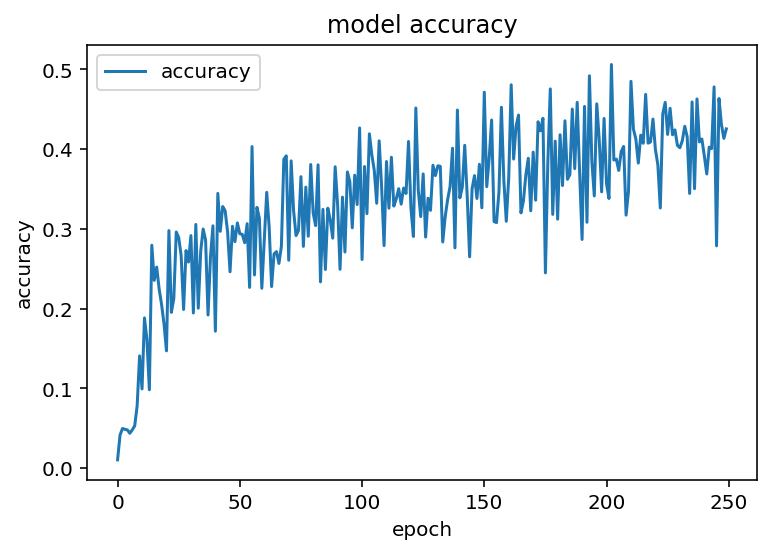

In [1207]:
print(his.history.keys())
plt.plot(his.history['accuracy'])
#plt.plot(his.history['loss'])
#plt.plot(history.val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()

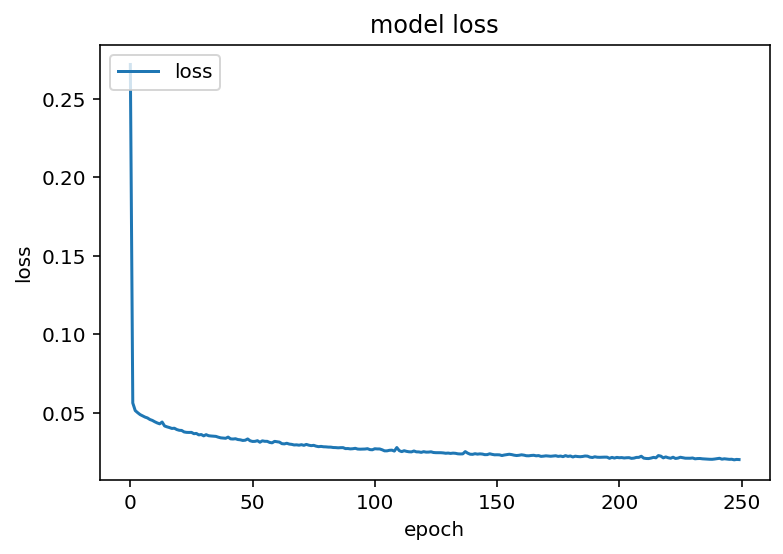

In [1206]:
plt.plot(his.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

In [1099]:
def Midi_to_Roll_compose(files_dir, ticks, lowest_note, factor):
    num_files = len(files_dir)        
        
    piano_roll = np.zeros((num_files, ticks, 44))
    
    for i, file_dir in enumerate(files_dir):
        file_path = "%s" %(file_dir)
        mid = MidiFile(file_path)
        note_time_onoff = getNoteTimeOnOffArray(mid, factor)
        note_on_length = getNoteOnLengthArray(note_time_onoff)
        #print("note_on_length ", note_on_length)
        for message in note_on_length:
            piano_roll[i, message[1]:(message[1]+int(message[2]/2)), message[0]-lowest_note] = 1
    
    return piano_roll

def createNetInputs_compose(roll, seq_length):

    testData = []
    seq_length = 16
    for song in roll:
        pos = 0
        X = []
        while pos+seq_length < song.shape[0]:
            sequence = np.array(song[pos:pos+seq_length])
            X.append(sequence)
            pos += 1
            
        testData.append(np.array(X))
    
    return np.array(testData)

def NetOutToPianoRoll(network_output, threshold):
    piano_roll = []
    #print("network_output:", network_output)
    for i, timestep in enumerate(network_output):
        #print("timestep:", timestep)
        print("timestep):", timestep)
        print("np.amax(timestep):", np.amax(timestep),np.argmax(timestep),i)
        if np.amax(timestep) > threshold:
            pos = 0
            pos = np.argmax(timestep)
            timestep[:] = np.zeros(timestep.shape)
            timestep[pos] = 1
        else:
            timestep[:] = np.zeros(timestep.shape)
        piano_roll.append(timestep)
        
    return np.array(piano_roll)

def Roll_to_Midi(piano_roll, lowest_note, directory, mel_test_file, threshold, factor):
    
    ticks_per_beat = int(960/factor)
    mid = MidiFile(type=0, ticks_per_beat=ticks_per_beat)
    track = MidiTrack()
    mid.tracks.append(track)

    mid_files = []
    

    delta_times = [0]
    for k in range(piano_roll.shape[1]):
        if piano_roll[0, k] == 1:
            track.append(Message('note_on', note=k+lowest_note, velocity=60, time=0))
            delta_times.append(0)
        
    for j in range(piano_roll.shape[0]-1):
        set_note = 0
        
        for k in range(piano_roll.shape[1]):
            if (piano_roll[j+1, k] == 1 and piano_roll[j, k] == 0) or (piano_roll[j+1, k] == 0 and piano_roll[j, k] == 1):#only do something if note_on or note_off are to be set
                if set_note == 0:
                    time = j+1 - sum(delta_times)       
                    delta_times.append(time)
                else:
                    time = 0
                    
                if piano_roll[j+1, k] == 1 and piano_roll[j, k] == 0:
                    set_note += 1
                    track.append(Message('note_on', note=k+lowest_note, velocity=60, time=time))
                if piano_roll[j+1, k] == 0 and piano_roll[j, k] == 1:
                    set_note += 1
                    track.append(Message('note_on', note=k+lowest_note, velocity=0, time=time))
                           
    mid.save('%s%s_th%s.mid' %(directory, mel_test_file, threshold))
    mid_files.append('%s.mid' %(mel_test_file))
       
    return

In [1208]:
test_dir = './testData/'
composition_dir = './compose/'

mel_files = glob.glob("%s*.mid" %(test_dir))

composition_files = []
for i in range(len(mel_files)):
    composition_files.append('%d' %(i+1))

harm_lowest_note = 31

factor = 120

mel_lowest_note, mel_highest_note, mel_ticks = getNoteRangeAndTicks(mel_files, factor)
print(mel_lowest_note,mel_highest_note, mel_ticks)
mel_roll = Midi_to_Roll_compose(mel_files, mel_ticks, mel_lowest_note, factor)

double_mel_roll = doubleRoll(mel_roll)

test_data = createNetInputs_compose(double_mel_roll, seq_length=mel_ticks)

for i, song in enumerate(test_data):
    print("song:", len(song))
    print("song:", song[0][:20])


60 87 1097
song: 2178
song: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0.

In [1221]:
batch_size = 128

thresh = 0.1

model_dir = './saved/'
model_files = listdir(model_dir)
print("Choose a file for the model:")
print("---------------------------------------")
for i, file in enumerate(model_files):
    print(str(i) + " : " + file)
print("---------------------------------------")
print()
file_number_model = int(input('File number:')) 
model_file = model_files[file_number_model]
model_path = '%s%s' %(model_dir, model_file)

#Load weights file
weights_dir = './weights/'
weights_files = listdir(weights_dir)
print()
print()
print("Choose a file for the weights:")
print("---------------------------------------")
for i, file in enumerate(weights_files):
    print(str(i) + " : " + file)
print("---------------------------------------")
print()
file_number_weights = int(input('File number:')) 
weights_file = weights_files[file_number_weights]
weights_path = '%s%s' %(weights_dir, weights_file)
model = model_from_json(open(model_path).read())
model.load_weights(weights_path)
model.compile(loss='binary_crossentropy', optimizer='adam')

print()
print("Compose...")
for i, song in enumerate(test_data):
    #print("song:", song)
    net_output = model.predict(song)
    #print("net_output:", net_output)
    net_roll = NetOutToPianoRoll(net_output, threshold=thresh)
    #print("net_roll:", net_roll)
    #print("net_roll.shape", net_roll.shape)
    Roll_to_Midi(net_roll, harm_lowest_note, composition_dir,composition_files[i], thresh, factor)
    
    print("Finished composing song %d." %(i+1))

print()    
print("Done!")

Choose a file for the model:
---------------------------------------
0 : 3layer_10epochs_20210815_21_01.json
1 : 3layer_200epochs_20210731_18_25.json
2 : 3layer_200epochs_20210731_18_34.json
3 : 3layer_200epochs_20210731_18_43.json
4 : 3layer_250epochs_20210802_16_35.json
5 : 3layer_250epochs_20210802_17_41.json
6 : 3layer_250epochs_20210813_00_57.json
7 : 3layer_250epochs_20210815_20_48.json
8 : 3layer_250epochs_20210815_20_55.json
9 : 3layer_250epochs_20210815_21_19.json
10 : 3layer_300epochs_20210731_19_00.json
11 : 3layer_300epochs_20210731_19_36.json
12 : 3layer_300epochs_20210731_20_10.json
13 : 3layer_300epochs_20210802_16_05.json
14 : 3layer_5epochs_20210815_21_07.json
15 : 3layer_5epochs_20210815_21_12.json
16 : 4layer_300epochs_20210731_19_22.json
---------------------------------------

File number:9


Choose a file for the weights:
---------------------------------------
0 : 3layer_10epochs_20210815_21_01.h5
1 : 3layer_200epochs_20210731_18_25.h5
2 : 3layer_200epochs_202107

np.amax(timestep): 0.86724705 22 261
timestep): [7.68360049e-02 1.23235315e-08 1.85163065e-27 0.00000000e+00
 6.02435896e-34 3.96236800e-21 4.92817249e-32 4.30178151e-14
 1.53196017e-27 4.75273371e-19 3.68725106e-10 0.00000000e+00
 3.71247530e-04 1.83341519e-38 6.43401790e-11 2.61418791e-06
 0.00000000e+00 5.26685629e-14 1.46623307e-37 6.13484826e-06
 0.00000000e+00 7.68479579e-24 2.61625182e-19 0.00000000e+00
 8.45592967e-06 0.00000000e+00 1.41483792e-27 3.27883062e-23
 3.80197627e-36 2.10217519e-32 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
np.amax(timestep): 0.076836005 0 262
timestep): [5.91257572e-01 1.07122512e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.35966472e-23 0.00000000e+00 2.59395469e-17
 9.51902468e-34 1.55112610e-25 7.61565422e-10 0.00000000e+00
 1.07682752e-07 0.00000000e+00 1.93555615e-17 7.42084723e-08
 0.00000000e+00 9.45906466e-19 0.00000000e+00 1.10578585e-05
 0.00000000e+00 1.70809798e-33 3.73205456e-23 0.00000000e+00
 1.11835050e-06 0.

timestep): [3.9564983e-24 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5643697e-20 0.0000000e+00 6.2419921e-38
 1.0942566e-22 0.0000000e+00 2.9669371e-13 0.0000000e+00 8.5853744e-17
 1.9545137e-08 7.4688825e-22 4.9981242e-01 1.0590215e-11 2.3381026e-12
 0.0000000e+00 3.0597375e-14 0.0000000e+00 3.1206413e-35 6.7219138e-05
 0.0000000e+00 9.1273559e-19 0.0000000e+00 5.6223394e-28 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
np.amax(timestep): 0.49981242 17 486
timestep): [1.1747759e-16 0.0000000e+00 0.0000000e+00 8.1110963e-31 2.5897618e-25
 2.9606027e-18 2.6783301e-23 4.0221481e-14 1.5921741e-25 4.2345586e-20
 2.6350966e-12 9.7701275e-38 9.8963646e-08 7.6715540e-24 1.3020667e-30
 4.2789283e-24 1.1841408e-01 3.7499373e-07 7.1210975e-11 8.9563476e-03
 5.8903447e-09 3.2437682e-02 3.3709700e-12 3.7590889e-05 4.3171763e-02
 1.9344773e-17 7.1695783e-10 1.4668038e-15 9.7322832e-15 5.6093334e-14
 4.0850959e-34 7.0489771e-24 4.

timestep): [6.7668921e-08 1.1567360e-29 3.1707614e-29 6.5658220e-21 1.4004322e-19
 8.2628591e-12 1.6865935e-16 1.7407445e-09 1.8460976e-14 1.6224353e-09
 5.7581965e-05 2.1817464e-20 2.6003842e-03 1.7347790e-13 5.0677423e-10
 4.7757178e-14 3.7823497e-07 4.4598240e-01 2.6193270e-08 6.1424210e-08
 2.6921917e-10 1.6093901e-01 2.7168605e-13 6.0261341e-06 4.9770764e-01
 2.9885179e-17 1.0623752e-06 4.0065190e-14 1.4978781e-03 1.8951653e-08
 2.4060566e-25 1.6461317e-09 4.2992559e-21 2.8078719e-31]
np.amax(timestep): 0.49770764 24 709
timestep): [2.4696361e-04 1.0797095e-17 0.0000000e+00 4.9756244e-15 1.7618059e-24
 2.6487147e-08 4.7698953e-17 2.0671040e-03 1.0275103e-11 1.3573366e-07
 3.1901014e-04 2.7141568e-13 1.8136772e-07 6.1232468e-26 8.2558870e-08
 1.7715577e-07 0.0000000e+00 2.5108579e-06 1.0288621e-28 1.9938536e-05
 2.3972698e-31 1.0795777e-13 1.9778700e-19 0.0000000e+00 1.3329809e-04
 0.0000000e+00 1.9820661e-08 4.2552525e-08 3.2053888e-04 4.7634046e-07
 5.3298792e-09 1.0116398e-04 1.

 2.02801506e-28 0.00000000e+00]
np.amax(timestep): 0.499232 24 900
timestep): [1.8861378e-08 2.3363228e-37 5.9892940e-36 2.6477119e-33 2.3592269e-19
 3.0114774e-15 3.5972412e-26 6.6267478e-18 7.1379672e-26 3.9620907e-31
 9.9495633e-17 8.8322717e-37 2.3856124e-08 1.8006326e-21 3.6460905e-27
 3.0746909e-25 9.1472240e-05 1.2655121e-09 1.8689495e-25 4.9342192e-04
 9.3161316e-18 3.3971184e-05 1.0831095e-01 5.5064358e-08 4.9763450e-01
 2.8044983e-17 3.1393166e-10 4.7752236e-15 1.0607345e-19 1.8168569e-15
 0.0000000e+00 4.8022998e-36 3.9254864e-32 0.0000000e+00]
np.amax(timestep): 0.4976345 24 901
timestep): [3.5748768e-10 5.3157372e-38 4.6520436e-37 1.1729961e-35 2.9050523e-21
 1.4990775e-20 4.9425477e-28 3.4949291e-18 7.0407925e-28 4.1394978e-34
 1.5101110e-17 0.0000000e+00 1.4107678e-10 5.6331537e-25 6.1199211e-29
 6.0307126e-24 4.1960776e-04 9.2034753e-09 3.1453954e-23 2.8490289e-03
 1.6590625e-19 2.7072410e-05 1.1321120e-01 3.9857859e-08 4.8440915e-01
 8.9520805e-14 6.9556603e-07 1.30603

timestep): [8.7942371e-06 3.1720579e-16 4.4896991e-19 7.9170173e-09 2.2204240e-08
 1.5441214e-02 3.2954290e-08 8.9496797e-07 1.8490519e-08 1.0064421e-06
 8.2409344e-05 6.3749988e-09 1.6613401e-03 6.0496279e-07 3.7729855e-09
 5.9284112e-11 1.7505653e-07 2.1989981e-03 8.6258778e-11 1.4959797e-03
 7.2051375e-04 1.9450044e-02 5.6820102e-03 7.5406564e-04 4.8675534e-01
 2.4278640e-06 1.5936546e-05 6.5032333e-01 1.6780758e-05 1.7882142e-02
 4.9613737e-07 4.4330786e-06 4.9593956e-09 2.0443533e-05]
np.amax(timestep): 0.65032333 27 1105
timestep): [2.9020684e-06 2.1595512e-18 4.6259518e-25 6.3570865e-10 7.9800628e-12
 1.5413971e-03 4.6548221e-10 2.0327536e-07 2.2967013e-09 3.4161172e-08
 2.0091024e-06 4.6666275e-09 1.8850562e-05 7.1794465e-10 2.7750753e-09
 2.8594475e-12 3.8856789e-17 3.2945603e-04 1.7215979e-16 4.3655408e-04
 1.0752217e-06 3.2334277e-04 6.0159680e-05 2.8480731e-09 8.5571289e-01
 3.3264258e-13 1.3664181e-05 7.1995270e-01 2.5802092e-05 6.9980007e-03
 2.1769905e-05 3.5575303e-04 4

 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
np.amax(timestep): 0.75885046 0 1322
timestep): [5.6603676e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5281179e-37 0.0000000e+00 2.6045614e-19 0.0000000e+00 1.6172321e-36
 1.8197456e-14 0.0000000e+00 1.2134224e-13 0.0000000e+00 2.9903324e-28
 2.0989346e-13 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7731064e-12
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1414805e-16
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
np.amax(timestep): 0.56603676 0 1323
timestep): [5.4804331e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 7.3727942e-24 0.0000000e+00 0.0000000e+00
 8.1301975e-19 0.0000000e+00 8.8492957e-16 0.0000000e+00 5.2009096e-34
 5.2858842e-16 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.7084330e-15
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.6027041e-20
 0.0000

np.amax(timestep): 0.22111887 0 1522
timestep): [9.42936301e-01 6.00245595e-03 3.69826117e-37 1.29468926e-27
 2.19313697e-23 2.15433801e-07 2.29134294e-24 4.63399197e-12
 1.15771573e-22 6.34871774e-17 2.05454098e-09 2.81085103e-31
 9.09715891e-05 2.60201242e-35 4.39972446e-18 1.01700664e-07
 0.00000000e+00 3.50676577e-19 0.00000000e+00 1.39651299e-02
 0.00000000e+00 7.57069564e-26 1.03151776e-09 0.00000000e+00
 9.51836228e-06 0.00000000e+00 1.46704931e-25 3.63427262e-06
 7.73122483e-38 6.50840771e-21 0.00000000e+00 0.00000000e+00
 5.85161605e-31 0.00000000e+00]
np.amax(timestep): 0.9429363 0 1523
timestep): [9.5381641e-01 5.7248771e-04 0.0000000e+00 2.6748503e-35 2.0826217e-28
 2.8191267e-11 1.1014135e-30 5.3307654e-15 2.8705182e-28 2.8586035e-23
 3.3163270e-13 0.0000000e+00 1.0768773e-06 0.0000000e+00 6.8520256e-23
 6.8140038e-10 0.0000000e+00 7.8418492e-23 0.0000000e+00 8.1149124e-02
 0.0000000e+00 9.6030027e-31 9.5069688e-11 0.0000000e+00 2.1436738e-06
 0.0000000e+00 3.1476794e-29 3

 1.8655199e-23 5.7717847e-23 7.3145904e-29 1.0048486e-35]
np.amax(timestep): 0.49949738 24 1775
timestep): [1.7129047e-09 2.0582969e-33 4.3054993e-33 3.6906364e-32 9.0953129e-21
 1.5835036e-21 9.8375846e-25 1.7451772e-16 2.8190771e-23 5.5154204e-24
 2.3655562e-07 6.1183090e-37 1.2768614e-07 2.7809260e-22 6.3080328e-19
 2.6203311e-16 3.9212629e-02 7.3747694e-02 1.1130771e-07 3.4096403e-05
 5.4635461e-18 4.6071969e-03 4.0181430e-06 4.1295002e-07 4.9987224e-01
 7.2135515e-09 5.9156737e-04 2.3206282e-14 8.2168788e-13 1.2418652e-10
 8.9859257e-26 5.9619476e-26 2.2363236e-33 0.0000000e+00]
np.amax(timestep): 0.49987224 24 1776
timestep): [1.9560577e-08 0.0000000e+00 2.6689407e-35 1.2769535e-33 6.6150907e-22
 5.9780892e-20 1.7266601e-26 1.1409568e-16 2.1894360e-23 2.5579171e-28
 5.5048206e-11 1.6505711e-35 6.0208926e-08 6.5692261e-21 2.3820610e-19
 3.9390987e-21 2.6593969e-05 4.3445051e-02 8.7996356e-15 5.7077494e-07
 3.6772944e-20 8.8195756e-02 3.1960559e-07 1.9365989e-07 4.9999240e-01
 4.83

 0.0000000e+00 5.7460790e-24 0.0000000e+00 0.0000000e+00]
np.amax(timestep): 0.013149653 12 1960
timestep): [3.5874432e-11 6.8391672e-32 3.2624100e-24 0.0000000e+00 0.0000000e+00
 1.2723077e-29 4.3760845e-27 1.1573126e-09 4.1573651e-23 1.5472381e-13
 9.9267143e-11 1.6724528e-38 3.2546304e-02 2.0464197e-26 1.0006130e-04
 5.5834901e-09 2.6175102e-16 8.8283420e-02 9.0604379e-13 2.3811970e-09
 2.6126623e-26 7.2187379e-07 1.3508132e-31 2.7084069e-20 1.0025710e-02
 0.0000000e+00 1.3540577e-19 0.0000000e+00 1.0864255e-13 9.1004440e-34
 0.0000000e+00 4.4237564e-25 0.0000000e+00 0.0000000e+00]
np.amax(timestep): 0.08828342 17 1961
timestep): [3.5694578e-15 0.0000000e+00 3.7641457e-32 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0443841e-33 5.2811252e-11 1.1603488e-28 4.9871050e-17
 1.4672753e-13 0.0000000e+00 2.6795515e-03 6.8202981e-34 1.0880765e-05
 2.1939651e-10 1.5261849e-20 3.3639342e-01 2.4556336e-13 6.9959288e-11
 1.2884776e-32 2.0203223e-07 0.0000000e+00 6.6460397e-25 2.8815866e-03
 0.0

Finished composing song 1.

Done!


In [1085]:
mid = MidiFile('./compose/1_th0.1.mid')
for track in mid.tracks:
    print(len(track))
    for message in track:
        if not isinstance(message, MetaMessage):
                print(message)

298
note_on channel=0 note=52 velocity=60 time=0
note_off channel=0 note=52 velocity=30 time=1
note_on channel=0 note=60 velocity=60 time=0
note_on channel=0 note=58 velocity=60 time=3
note_off channel=0 note=60 velocity=30 time=0
note_off channel=0 note=58 velocity=30 time=5
note_on channel=0 note=62 velocity=60 time=0
note_on channel=0 note=58 velocity=60 time=2
note_off channel=0 note=62 velocity=30 time=0
note_off channel=0 note=58 velocity=30 time=1
note_on channel=0 note=60 velocity=60 time=0
note_on channel=0 note=57 velocity=60 time=1
note_off channel=0 note=60 velocity=30 time=0
note_on channel=0 note=55 velocity=60 time=6
note_off channel=0 note=57 velocity=30 time=0
note_off channel=0 note=55 velocity=30 time=5
note_on channel=0 note=57 velocity=60 time=0
note_on channel=0 note=55 velocity=60 time=3
note_off channel=0 note=57 velocity=30 time=0
note_on channel=0 note=53 velocity=60 time=2
note_off channel=0 note=55 velocity=30 time=0
note_off channel=0 note=53 velocity=30 ti

In [1050]:
mid.ticks_per_beat

4

2.4.3
